In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copairs import map
from copairs.map.average_precision import p_values
from copairs.matching import assign_reference_index

In [14]:
# generate two dataframes each with 100 random samples with overlapping distributions across 100 features
np.random.seed(0)  # for reproducibility
df = pd.DataFrame(
    np.random.gamma(0.5, 1, (100, 100)), columns=[f"feature_{i}" for i in range(100)]
)
df2 = pd.DataFrame(
    np.random.normal(0.5, 0.1, (100, 100)), columns=[f"feature_{i}" for i in range(100)]
)

df["Metadata_ID"] = 1
df2["Metadata_ID"] = 2
# concatenate the two dataframes
df_combined = pd.concat([df, df2], ignore_index=True)
print(df_combined.shape)
df_combined.head()

(200, 101)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,Metadata_ID
0,0.304002,0.378272,0.179483,0.191483,0.879609,0.328493,0.005046,0.000409,0.821413,4.309931,...,0.142696,0.000609,0.521567,0.289429,0.486337,0.000426,0.102411,0.356621,0.421433,1
1,0.074825,0.034461,0.540200,2.642792,0.064486,0.043044,0.140003,0.077078,1.323526,0.615178,...,0.058283,0.060547,0.267925,0.311271,0.587511,0.129993,0.054115,0.994080,3.571549,1
2,0.087946,0.062210,0.655141,0.074222,0.140098,0.056552,0.201863,1.138894,0.252401,0.430315,...,0.058350,1.288198,0.208903,0.179527,0.013763,0.163049,0.503899,0.606686,0.159330,1
3,1.035420,0.642186,0.012205,0.164328,0.000897,0.012053,0.578823,1.352007,0.287506,0.275403,...,0.792394,0.020024,0.194765,0.201035,0.408013,1.348699,0.161144,0.972203,0.044713,1
4,1.433459,0.014429,0.030755,1.320280,0.135363,0.742222,0.474589,0.235192,0.311217,0.801153,...,0.308643,0.424684,0.016389,0.000004,0.438272,2.656810,0.108670,0.011700,0.048937,1


In [15]:
df_combined_copy = df_combined.copy()
final_ap_results = {
    "reference_index": [],
    "activity_ap_df": [],
}
final_mAP_results = {
    "reference_index": [],
    "activity_map_df": [],
}

for reference_ in [1, 2]:
    reference_col = "Metadata_reference_index"
    df_sc_activity = assign_reference_index(
        df_combined_copy,
        f"Metadata_ID == {reference_}",  # condition to get reference profiles (neg controls)
        reference_col=reference_col,
        default_value=-1,
    )

    # positive pairs are replicates of the same treatment
    pos_sameby = ["Metadata_ID", reference_col]
    pos_diffby = []

    neg_sameby = []
    # negative pairs are replicates of different treatments
    neg_diffby = ["Metadata_ID", reference_col]
    metadata = df_sc_activity.filter(regex="^Metadata")
    profiles = df_sc_activity.filter(regex="^(?!Metadata)").values

    activity_sc_ap = map.average_precision(
        metadata, profiles, pos_sameby, pos_diffby, neg_sameby, neg_diffby
    )

    activity_sc_ap = activity_sc_ap.query(f"Metadata_ID != {reference_}")  # remove DMSO

    activity_map = map.mean_average_precision(
        activity_sc_ap, pos_sameby, null_size=1000000, threshold=0.05, seed=0
    )
    final_ap_results["reference_index"].append(reference_)
    final_ap_results["activity_ap_df"].append(activity_sc_ap)
    final_mAP_results["reference_index"].append(reference_)
    final_mAP_results["activity_map_df"].append(activity_map)
final_mAP_results_df = pd.concat(
    final_mAP_results["activity_map_df"], keys=final_mAP_results["reference_index"]
)
final_mAP_results_df.reset_index(inplace=True)
final_mAP_results_df.head()
final_ap_results_df = pd.concat(
    final_ap_results["activity_ap_df"], keys=final_ap_results["reference_index"]
)
final_ap_results_df.reset_index(inplace=True)
final_ap_results_df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,level_0,level_1,Metadata_ID,Metadata_reference_index,n_pos_pairs,n_total_pairs,average_precision
0,1,100,2,-1,99,199,1.0
1,1,101,2,-1,99,199,1.0
2,1,102,2,-1,99,199,1.0
3,1,103,2,-1,99,199,1.0
4,1,104,2,-1,99,199,1.0


<Axes: xlabel='Metadata_ID', ylabel='average_precision'>

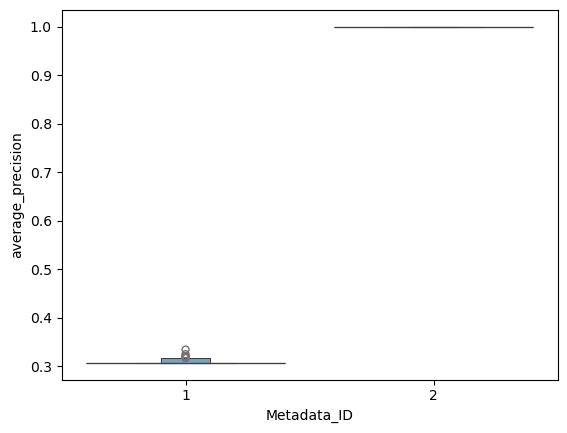

In [16]:
sns.boxenplot(
    data=final_ap_results_df,
    x="Metadata_ID",
    y="average_precision",
)

<Axes: xlabel='Metadata_ID', ylabel='mean_average_precision'>

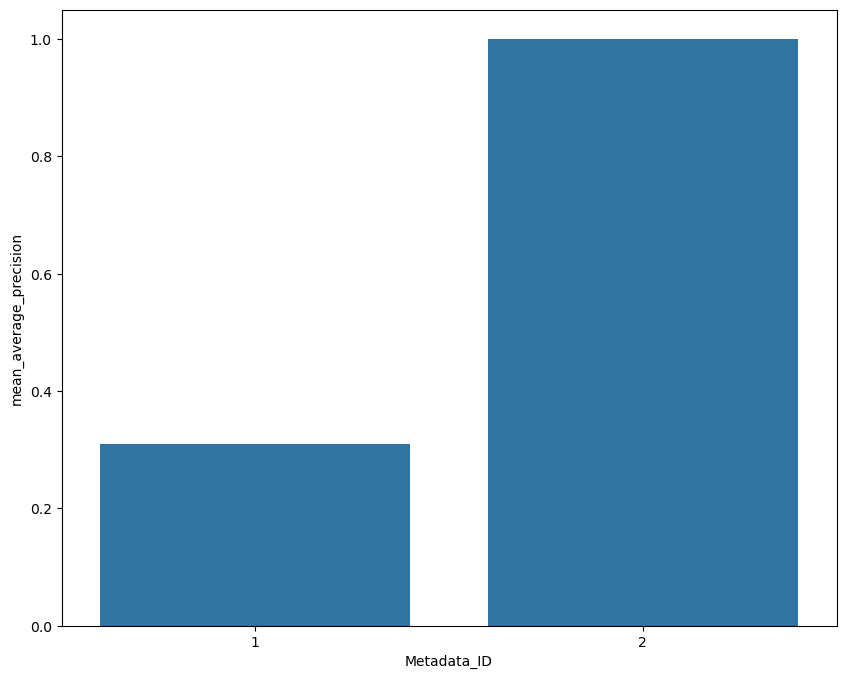

In [17]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=final_mAP_results_df,
    x="Metadata_ID",
    y="mean_average_precision",
)